# Лабораторная работа №5

In [1]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

Вариант:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [2]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike, NDArray
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Часть 1. Построение автоэнкодера на основе изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

Подготовка модулей и переменных для работы с файлами.

In [ ]:
import os  # noqa
import shutil  # noqa
import urllib  # noqa
from pathlib import Path  # noqa

data_path = Path("data")
external_data_path = data_path / "external"
interim_data_path = data_path / "interim"
processed_data_path = data_path / "processed"

external_data_path.mkdir(exist_ok=True)
interim_data_path.mkdir(exist_ok=True)
processed_data_path.mkdir(exist_ok=True)

Подготовка модулей и переменных для загрузки CIFAR100.

In [66]:
url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"

external_data_path.mkdir(exist_ok=True)

file_path = external_data_path / filename

Загрузка CIFAR100.

In [68]:
# After extracting a new dir will be created so no need to create it manually.
if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=external_data_path)
    file_path.unlink()  # Remove archive after extracting it.

### Чтение тренировочной и тестовой выборки

In [69]:
def stem_extensions(filename: Path):
    """
    Stem extensions from file (including multi-part extensions like ".tar.gz").

    returns: filename without extensions and trimmed string with extensions (without leading dot).
    """
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions), extensions[1:]

In [73]:
dataset_path, _ = stem_extensions(file_path)
dataset_path = Path(dataset_path)

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [74]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [75]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


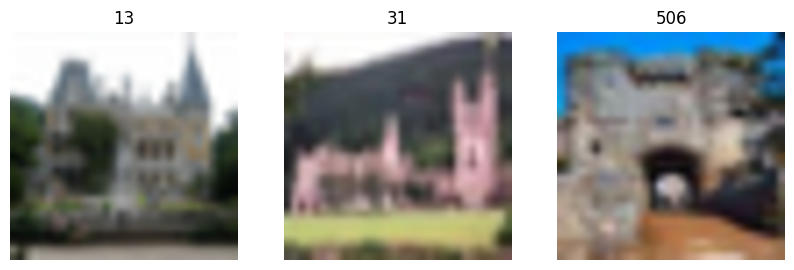

class_id = 70:


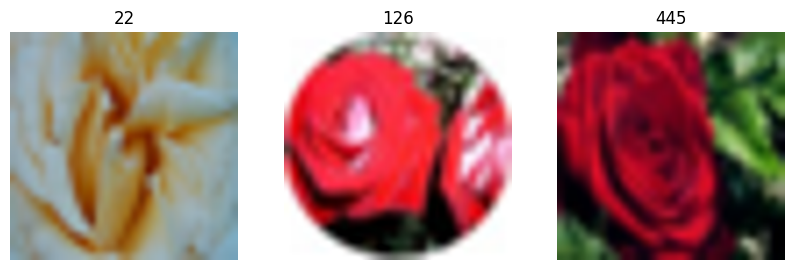

class_id = 35:


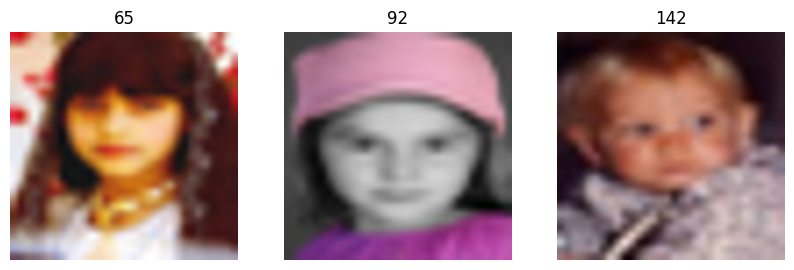

In [76]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Cifar Dataset с аугментацией

In [77]:
from torch import Tensor  # noqa
from torch.utils.data import Dataset  # noqa


class CifarDataset(Dataset):
    def __init__(self, X: Tensor, y: Tensor, transform=None, p=0.0):
        assert X.size(0) == y.size(0)
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        self.transform = transform
        self.prob = p

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform and np.random.random() < self.prob:
            X = self.transform(X.permute(2, 0, 1) / 255).permute(1, 2, 0) * 255

        y = self.y[index]

        return X, y

Попробуем применить аугментацию к одной из картинок.

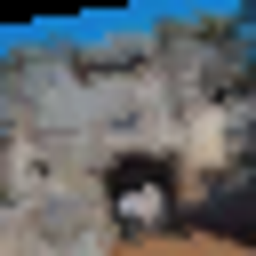

In [78]:
import torchvision.transforms as T  # noqa

transform = T.Compose(
    [
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
        # shear - сдвиг.
        T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    ]
)

Image.fromarray(
    (CifarDataset(Tensor(train_X), Tensor(train_y), transform=transform, p=1)[10])[0]
    .numpy()
    .astype(np.uint8)
).resize((256, 256))

### Создание Pytorch DataLoader'a

In [79]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = CifarDataset(
            tensor_x, tensor_y, transform=transform if part == "train" else None, p=0.5
        )  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            prefetch_factor=8 if part == "train" else 2,
            num_workers=2,
            persistent_workers=True,
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели-автоэнкодера

In [80]:
HIDDEN_SIZE = 512


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        # NEW: instead of permute now flattenning. Othewise shape will be
        # different.
        return torch.flatten(x, start_dim=1) # nhw -> nm


class Cifar100_AE(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=len(CLASSES)):
        super(Cifar100_AE, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ELU(),
            nn.Linear(hidden_size // 2, hidden_size // 8),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size // 8, hidden_size // 2),
            nn.ELU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 32 * 32 * 3),
        )

    def forward(self, input):
        normed = self.norm(input)
        encoded = self.encoder(normed)
        out = self.decoder(encoded)
        return out, encoded, normed


model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
summary(model, input_size=(32, 32, 3))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1                 [-1, 3072]               0
            Linear-2                  [-1, 512]       1,573,376
               ELU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
               ELU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
              Tanh-7                   [-1, 64]               0
            Linear-8                  [-1, 256]          16,640
               ELU-9                  [-1, 256]               0
           Linear-10                  [-1, 512]         131,584
              ELU-11                  [-1, 512]               0
           Linear-12                 [-1, 3072]       1,575,936
Total params: 3,445,312
Trainable params: 3,445,312
Non-trainable params: 0
---------------------------

Cifar100_AE(
  (norm): Normalize()
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=512, out_features=3072, bias=True)
  )
)

### Создание логов для Tensorboard

In [81]:
import time  # noqa

from torch.utils.tensorboard import SummaryWriter  # noqa

%load_ext tensorboard

current_time = str(int(time.time()))

run_path = Path("runs/tensorboard")

train_run_path = run_path / "train" / current_time
test_run_path = run_path / "test" / current_time

train_summary_writer = SummaryWriter(log_dir=train_run_path)
test_summary_writer = SummaryWriter(log_dir=test_run_path)

## Обучение

In [82]:
REDRAW_EVERY = 20
# New: Changed epochs.
EPOCHS = 200

from sklearn.metrics import r2_score


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    scheduler: optim.lr_scheduler.LRScheduler = None,
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    pbar = tqdm(total=epochs * steps_per_epoch)
    losses = []
    losses_val = []
    passed = 0
    # Для создания чекпоинта
    best_acc = 0
    checkpoint_path = Path("cifar_autoencoder.pth")

    for epoch in range(epochs):  # проход по набору данных несколько раз
        tmp = []
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, _ = batch
            # NEW:
            inputs, _ = inputs.to(device), _.to(device)

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            # NEW: outputs[0] (out) and outputs[2] (norm) instead of outputs and label.
            loss = criterion(outputs[0], outputs[2])
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            # NEW: r2_score instead of mean of max.
            accuracy = (
                r2_score(
                    outputs[2].detach().cpu().numpy(), outputs[0].detach().cpu().numpy()
                )
                * 100
            )
            tmp.append((loss.item(), accuracy.item()))
            pbar.update(1)

            with train_summary_writer as writer:
                writer.add_scalar("loss", tmp[-1][0], global_step=pbar.n)
                writer.add_scalar("accuracy", tmp[-1][1], global_step=pbar.n)

        losses.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )

        if scheduler:
            scheduler.step()  # Обновляем learning_rate каждую эпоху.

        tmp = []
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, _ = data
                # на GPU
                inputs, _ = inputs.to(device), _.to(device)

                outputs = model(inputs)
                # NEW: Taking certain indices of outputs instead of whole outputs and label tensors.
                loss = criterion(outputs[0], outputs[2])
                # NEW: r2_score instead of mean of max.
                accuracy = (
                    r2_score(
                        outputs[2].detach().cpu().numpy(),
                        outputs[0].detach().cpu().numpy(),
                    )
                    * 100
                )
                tmp.append((loss.item(), accuracy.item()))
        losses_val.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        with test_summary_writer as writer:
            writer.add_scalar("loss", losses_val[-1][0][0], global_step=pbar.n)
            writer.add_scalar("accuracy", losses_val[-1][0][1], global_step=pbar.n)

        acc = losses_val[-1][0][1]
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), checkpoint_path)

        # Обновление графиков.
        if (epoch + 1) % REDRAW_EVERY != 0:
            continue
        clear_output(wait=False)
        print(
            "Эпоха: %s\n"
            "Лучшее значение метрики: %s\n"
            "Текущее значение метрики: %s" % (epoch + 1, best_acc, acc)
        )
        passed += pbar.format_dict["elapsed"]
        pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
        pbar.update((epoch + 1) * steps_per_epoch)
        x_vals = np.arange(epoch + 1)
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        stats = np.array(losses)
        stats_val = np.array(losses_val)
        ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
        ax[1].grid(axis="y")
        for i, title in enumerate(["MSE", "Accuracy"]):
            ax[i].plot(x_vals, stats[:, 0, i], label="train")
            ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
            ax[i].plot(x_vals, stats_val[:, 0, i], label="val")
            ax[i].fill_between(
                x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4
            )
            ax[i].legend()
            ax[i].set_title(title)
        plt.show()

    model.load_state_dict(torch.load(checkpoint_path))
    print("Обучение закончено за %s секунд" % passed)

    return dataloader

In [83]:
# Запуск tensorboard в Jupyter Notebook.
%tensorboard --logdir runs/tensorboard

### Выбор функции потерь и оптимизатора градиентного спуска

Эпоха: 200
Лучшее значение метрики: 83.05285503153573
Текущее значение метрики: 82.84360777362566


100%|██████████| 2400/2400 [00:03<00:00, 788.26it/s]


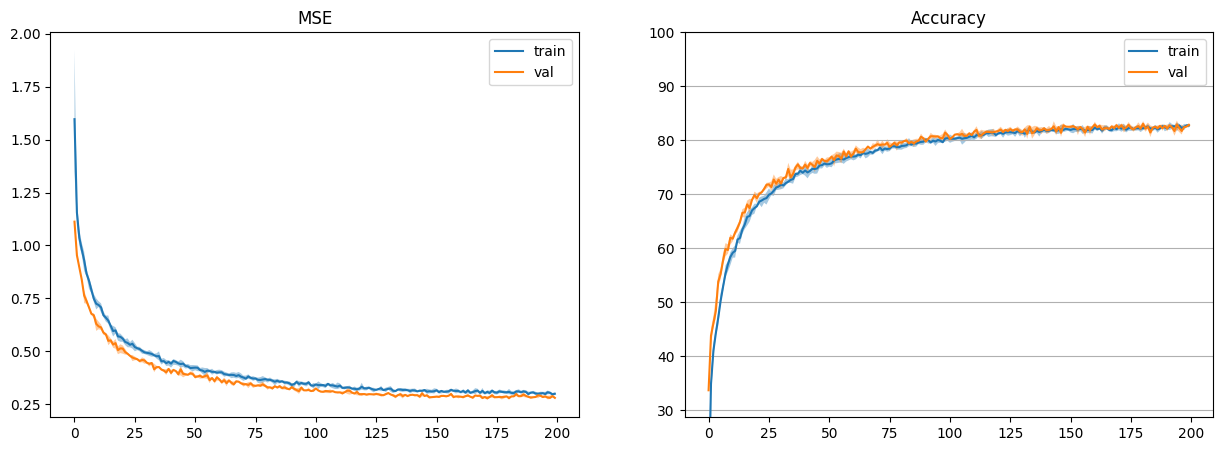

100%|██████████| 2400/2400 [00:00<00:00, 17746.88it/s]

Обучение закончено за 32.86958408355713 секунд


In [84]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
# New weight_decay ruins metrics a lot.
WEIGHT_DECAY = 0

def train_autoencoder(
    model: nn.Module,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    # Регуляризация модели за счёт коэффициента, учитывающего сложность модели.
    # Норма параметров будет прибавлена к функции потерь. Чем больше
    # weight_decay, тем сильнее штраф за сложность.
    weight_decay=1e-5,
    # Постепенное уменьшение шага обучения каждые N эпох.
    scheduler_step_size=240,
):
    # NEW: MSELoss instead of CrossEntropyLoss because we are not doing
    # classification now. Also it doesn't have label smoothing.
    criterion = nn.MSELoss()
    # NEW: Adam instead of SGD. It doesn't have momentum param.
    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )
    dataloader = create_dataloader(batch_size=batch_size)
    # Добавляем постепенное уменьшение шага обучения каждые step_size
    #   эпох.
    scheduler = optim.lr_scheduler.StepLR(
        optimizer=optimizer, step_size=scheduler_step_size, gamma=0.5
    )

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
        # scheduler=scheduler,
    )


dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY)

### Проверка качества модели по классам на обучающей и тестовой выборках

In [85]:
def get_encoder_results(model: Cifar100_AE, dataloader: DataLoader):
    embeddings = []
    images = []
    reconstructs = []
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader['test'], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # очищение прошлых градиентов с прошлой итерации
            # optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            out, embedding, norm = model(inputs)
            embeddings.append(embedding.detach().cpu().numpy())
            images.append(inputs.detach().cpu().numpy())
            reconstructs.append(out.detach().cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    images = np.concatenate(images, axis=0)
    reconstructs = np.concatenate(reconstructs, axis=0)
    reconstructs = (reconstructs-reconstructs.min())/(reconstructs.max()-reconstructs.min())

    return {
        "embeddings": embeddings,
        "images": images,
        "reconstructs": reconstructs,
    }

In [86]:
results = get_encoder_results(model, dataloader)

#### Визуализация эмбеддингов

In [87]:
# Тут мы применяем уменьшение размерности к многомерному
# эмбеддингу, полученному из бутылочного горлышка автоэнкодера.
# Можете попробовать сделать число нейронов равное 2
# и тогда данный этап можно пропустить и написать просто:
# projection = embeddings

from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_images_embeddings(images: NDArray, embeddings: NDArray):
    projections = PCA(n_components=2).fit_transform(embeddings)

    def implot(x, y, image, ax, zoom=1):
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    for img, x in zip(images, projections):
        img = img.reshape(32, 32, 3)/255.
        implot(x[0], x[1], img, ax=ax, zoom=0.5)

#### Визуализация восстановленной картинки

In [88]:
from ipywidgets import interact

def report_encoder_results(images: NDArray, reconstructs: NDArray, embeddings: NDArray):
    def draw_comparision(index: int):
       fig, ax = plt.subplots(1, 2, figsize=(10, 5))
       ax[0].imshow(images[index].reshape(32,32,3)/255.)
       ax[1].imshow(reconstructs[index].reshape(32,32,3))
       ax[0].set_title('Оригинал')
       ax[1].set_title('Восстановленное изображение')

    interact(draw_comparision, index=(0, len(images) - 1))

    visualize_images_embeddings(images, embeddings)

Как видно, получившиеся embedding'и образуют некоторые кластеры.

interactive(children=(IntSlider(value=149, description='index', max=299), Output()), _dom_classes=('widget-int…

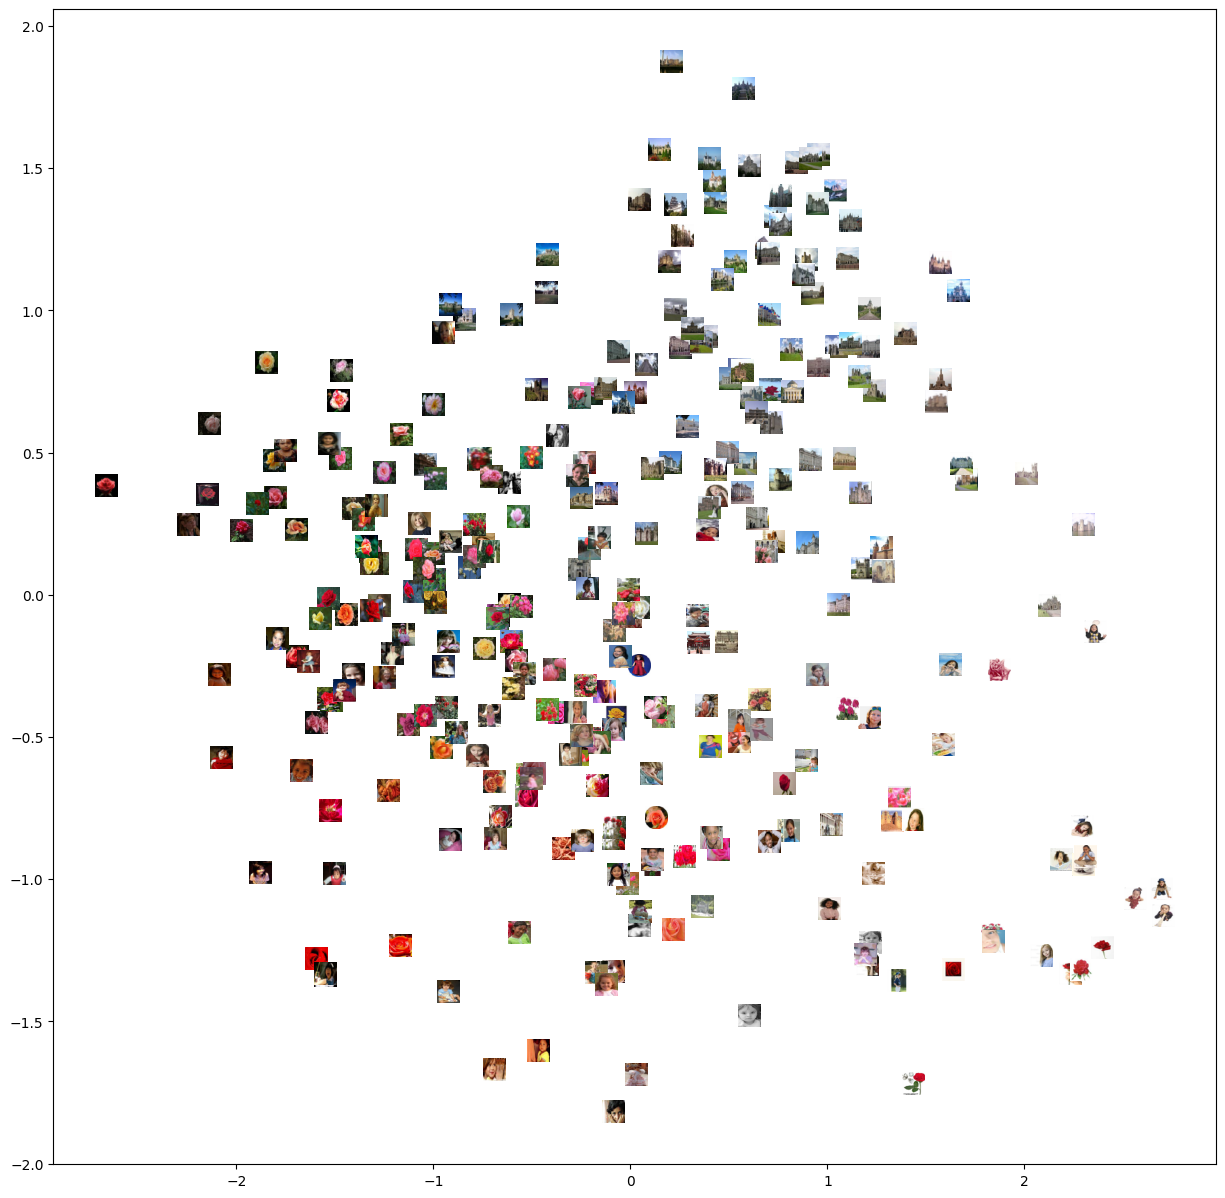

In [89]:
report_encoder_results(**results)

### Подберём гиперпараметры
#### batch size и epochs
Меняем их параллельно (одно уменьшили в два раза, следовательно другое
увеличили в два раза)

Эпоха: 200
Лучшее значение метрики: 82.69053735577312
Текущее значение метрики: 82.26590865230315


100%|██████████| 2400/2400 [00:03<00:00, 774.10it/s]


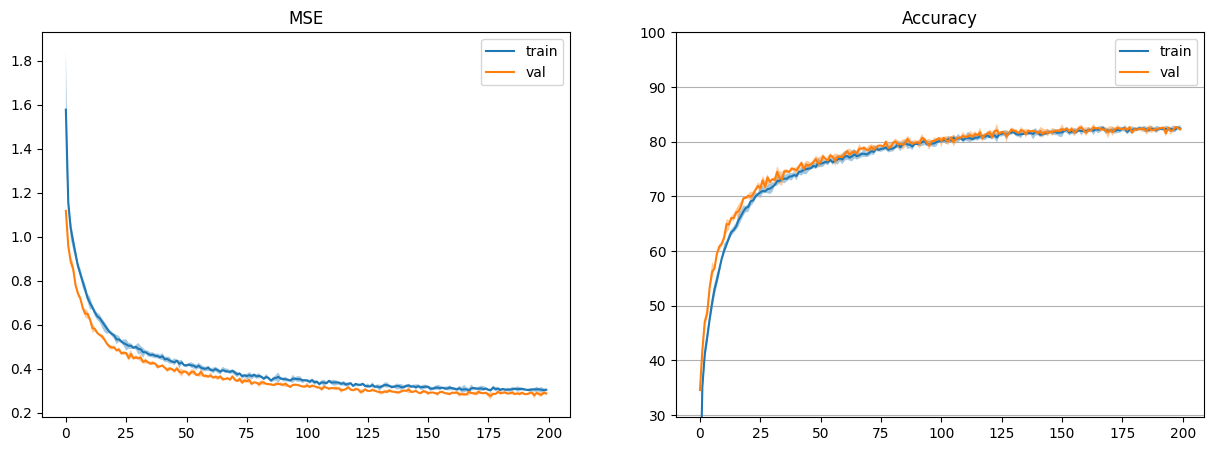

100%|██████████| 2400/2400 [00:00<00:00, 15779.55it/s]

Обучение закончено за 32.728559255599976 секунд


interactive(children=(IntSlider(value=149, description='index', max=299), Output()), _dom_classes=('widget-int…

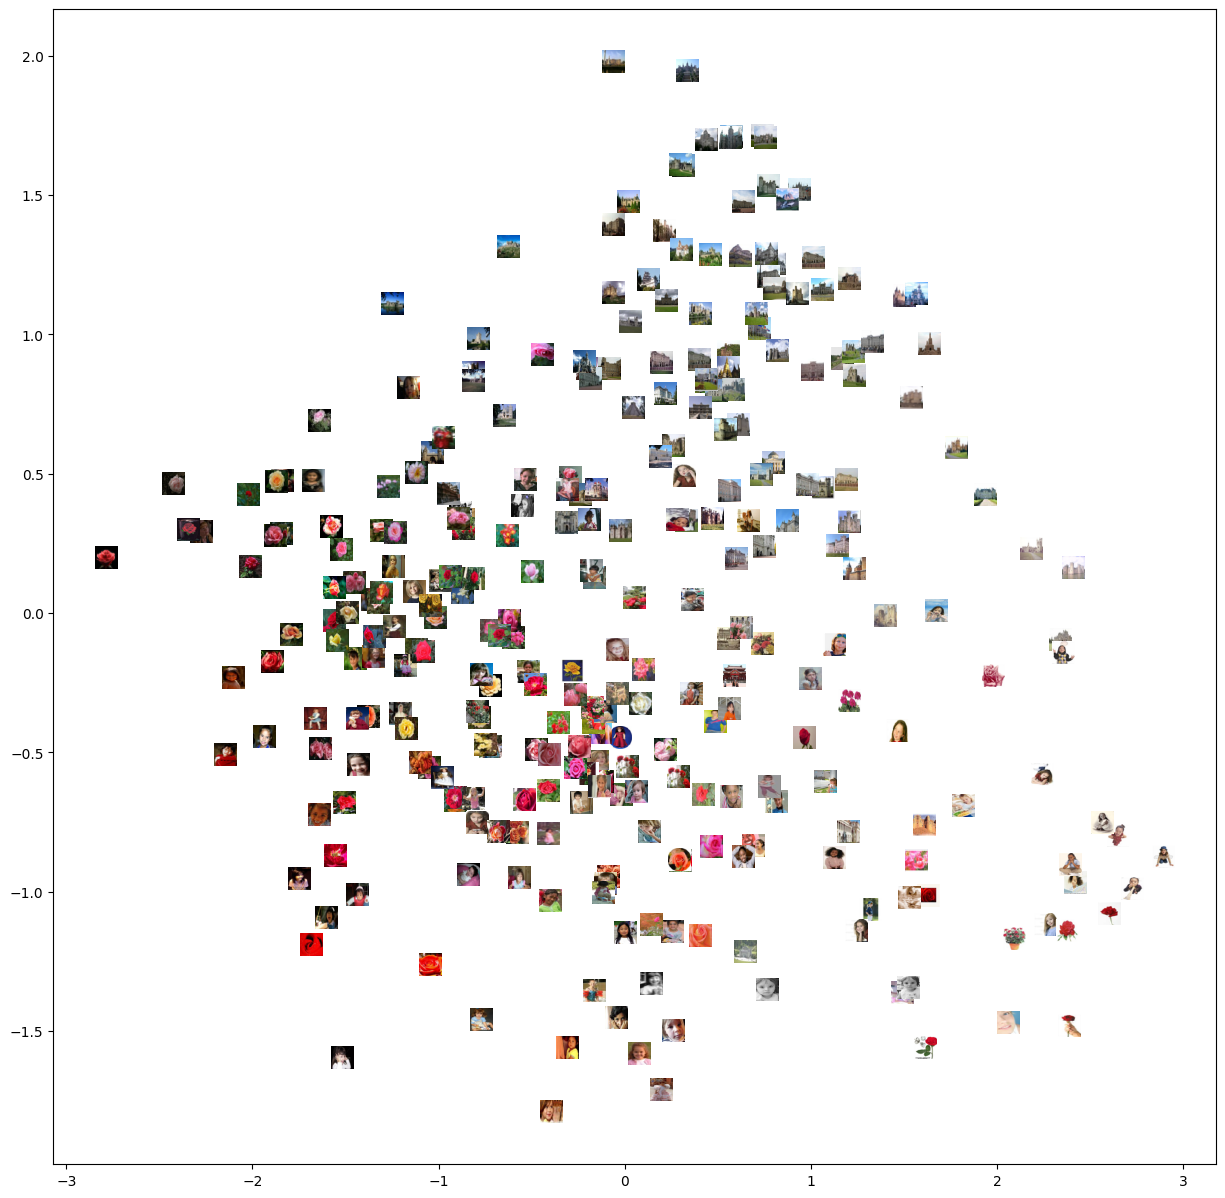

In [90]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

Эпоха: 400
Лучшее значение метрики: 81.86268632327298
Текущее значение метрики: 80.73698138334352


9600it [00:03, 3069.31it/s]:00<?, ?it/s]


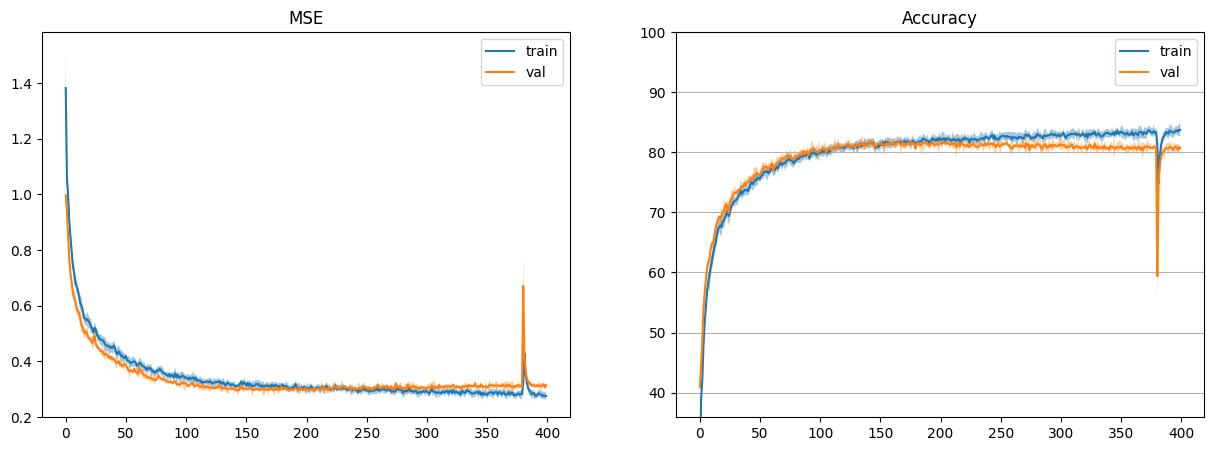

9600it [00:00, 63814.14it/s]            

Обучение закончено за 64.63674330711365 секунд


interactive(children=(IntSlider(value=149, description='index', max=299), Output()), _dom_classes=('widget-int…

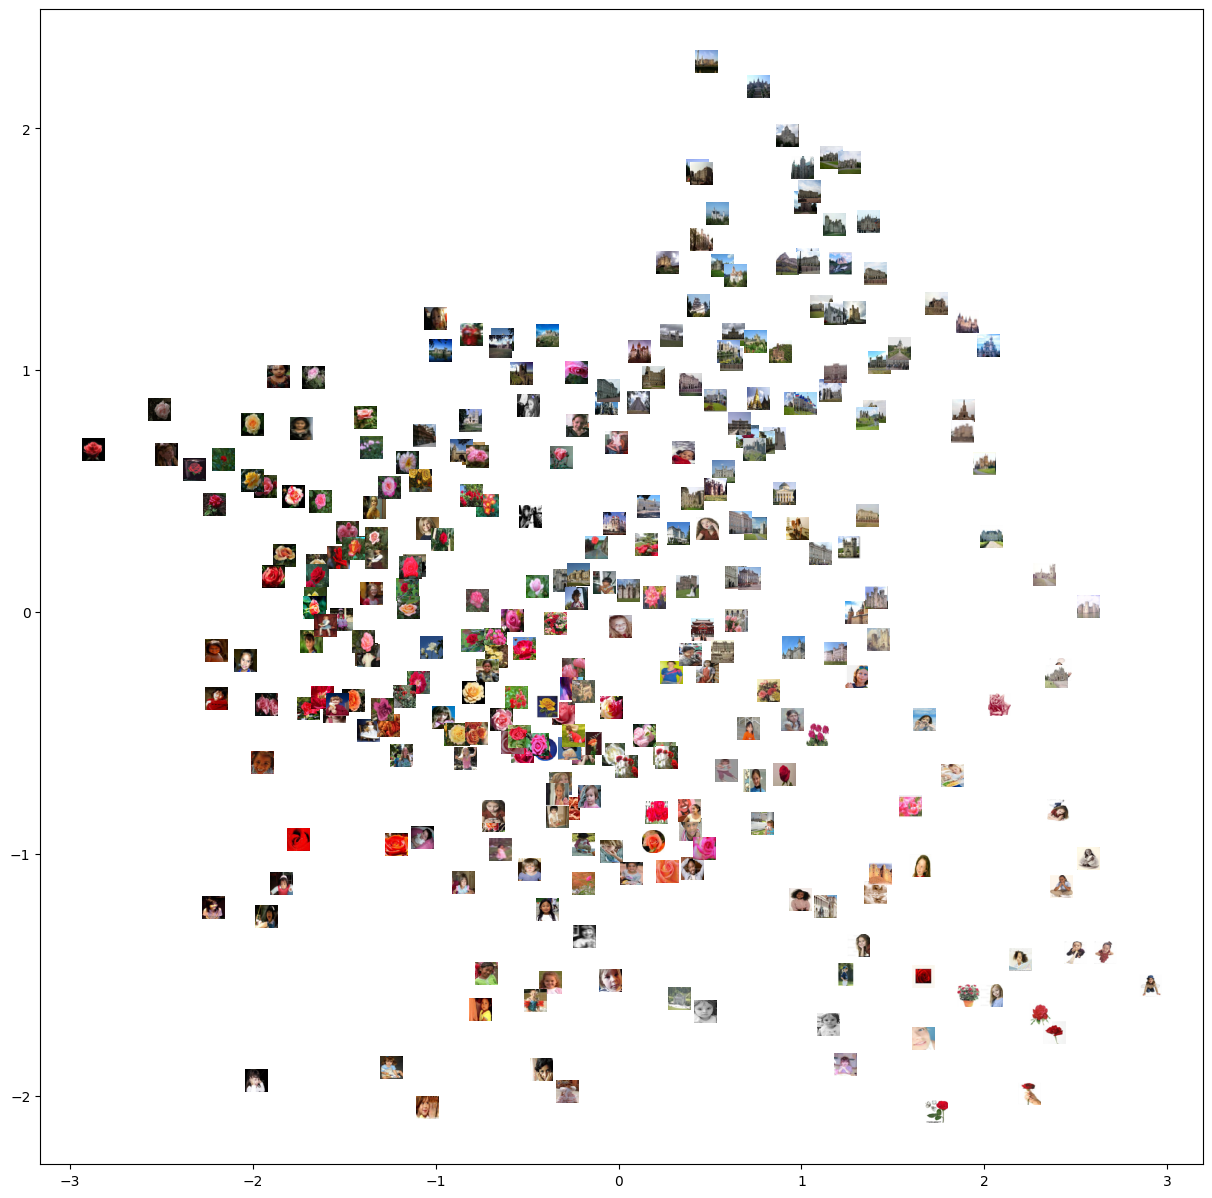

In [91]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, batch_size=int(BATCH_SIZE / 2), epochs=EPOCHS * 2)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

Эпоха: 140
Лучшее значение метрики: 79.48029232844888
Текущее значение метрики: 78.1340098601702



 70%|███████   | 6580/9400 [00:03<00:01, 1941.88it/s]


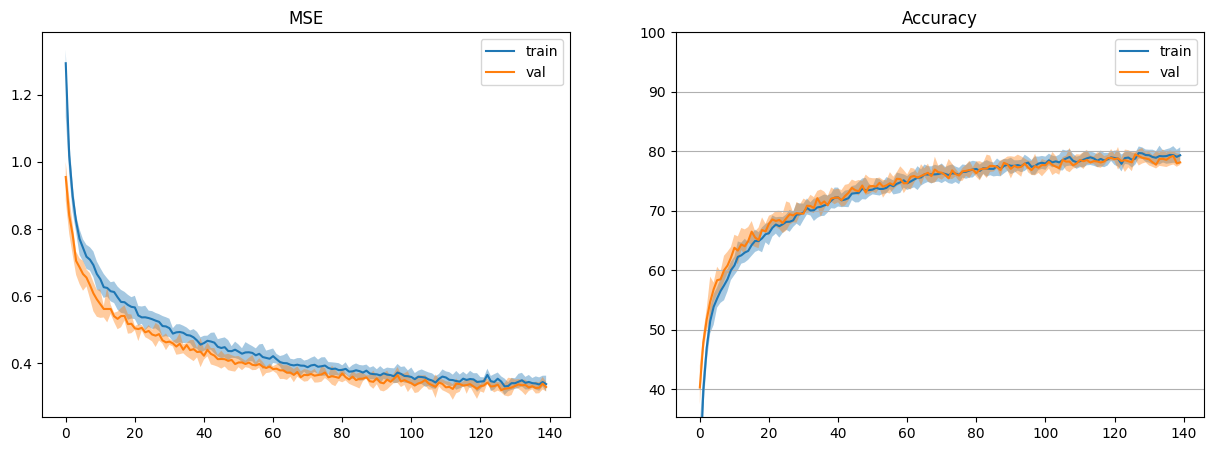


 75%|███████▍  | 7004/9400 [00:01<00:05, 420.03it/s]

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, batch_size=int(BATCH_SIZE / 4), epochs=EPOCHS * 4)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, batch_size=BATCH_SIZE * 4, epochs=int(EPOCHS / 4))
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, batch_size=BATCH_SIZE * 2, epochs=int(EPOCHS / 2))
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

Как видно, при количестве эпох меньше 100 наблюдается недообучение. При
количестве эпох больше 200 - переобучение. Лучший результат ~83%.
Зафиксируем среднее - 200 эпох и соответствующий этому batch size:

In [ ]:
OPTIMAL_EPOCHS = 200
OPTIMAL_BATCH_SIZE = int(BATCH_SIZE * (OPTIMAL_EPOCHS / EPOCHS))
OPTIMAL_BATCH_SIZE

#### learning rate
learning rate также стоит менять вместе с epochs либо batch_size
параллельно для сохранения количества итерация константным.
Будем при увеличении learning_rate в n раз уменьшать epochs в n раз.

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=LEARNING_RATE * 2, batch_size=OPTIMAL_BATCH_SIZE, epochs=int(OPTIMAL_EPOCHS / 2))
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=LEARNING_RATE * 4, batch_size=OPTIMAL_BATCH_SIZE, epochs=int(OPTIMAL_EPOCHS / 4))
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=int(LEARNING_RATE / 4), batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS * 4)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=int(LEARNING_RATE / 2), batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS * 2)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

В итоге изменение learning_rate не принесло плодов: начальный был оптимальным.

In [ ]:
OPTIMAL_LEARNING_RATE = LEARNING_RATE

#### hidden size

In [ ]:
model = Cifar100_AE(hidden_size=HIDDEN_SIZE)
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE * 2))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE * 4))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE * 4))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY + 1e-5, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE * 4))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY + 2e-5, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE / 2))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE / 4))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

In [ ]:
model = Cifar100_AE(hidden_size=int(HIDDEN_SIZE / 8))
model.to(device)
dataloader = train_autoencoder(model, weight_decay=WEIGHT_DECAY, learning_rate=OPTIMAL_LEARNING_RATE, batch_size=OPTIMAL_BATCH_SIZE, epochs=OPTIMAL_EPOCHS)
results = get_encoder_results(model, dataloader)
report_encoder_results(**results)

Вполне закономерно, увеличение hidden_size ведёт к улучшение модели.
В итоге наилучшим HIDDEN_SIZE оказалось значение, увеличенное вдвое - 86,5%. При
дальнейшем увеличении параметра, начинается переобучение. Поставив
weight_decay = 1e-5, мы уменьшили переобучение. При weight_decay = 2e-5 мы
полностью устранили переобучение, достигнув 82%. Этот результат хуже
предыдущих вариантов, при этом модель обучается дольше в 1.5 раза.

### Анализ результатов обучения модели автоэнкодера
Автоэнкодер позволяет построить эмбеддинги, по которым, например, можно в будущем реализовывать кластеризацию.

По результатам наших экспериментов с гиперпараметрами видно, что автоэнкодер по сравнению с нейронными
сетями из предыдущих лабораторных работ начинает переобучаться довольно поздно. Из-за этого, например, мы почти не пользовались
weight_decay и совершенно отбросили scheduler.

## Часть 2. Очистка звука

Подготовка модулей и переменных для работы с аудио файлами.

In [12]:
import subprocess
from pathlib import Path

external_audio_data_path = external_data_path / "audio"
external_audio_data_path.mkdir(exist_ok=True)

Подготовка модулей и переменных для работы с музыкой, с которой мы собираемся
экспериментировать.

In [45]:
# Поменять на музыку, с которой хотите эксперементировать.
filename = "Arcanum.mp3"
audio_path = external_audio_data_path / filename

start_time = "00:00:00"
finish_time = "00:00:15"

str(audio_path), str(stem_extensions(audio_path))

('data/audio/Arcanum.mp3', "('data/audio/Arcanum', 'mp3')")

### Подготовка файла музыки
Создадим функцию, которая с помощью ffmpeg поможет нам обрезать звуковой
файл.

In [55]:
def cut_audio(audio_path: Path, start_time: str = "00:00:00", finish_time: str = "00:00:15") -> Path:
    """
    returns (Path): file path of the resulting file
    """
    if not audio_path.exists():
        raise Exception(f"No file {audio_path} exists!")

    audio_filename_without_extensions, trimmed_extensions = stem_extensions(audio_path)
    output_file_path = f"{audio_filename_without_extensions}--cut.{trimmed_extensions}"

    subprocess.run([
        "ffmpeg",
        "-y", # Allow overwriting file if it exists.
        "-ss",
        start_time,
        "-to", finish_time,
        "-i", str(audio_path),
        "-c", "copy",
        output_file_path,
    ])

    return Path(output_file_path)

Возьмём первые 15 секунд, всё остальное обрежем.

In [56]:
try:
    cut_audio_file_path = cut_audio(audio_path=audio_path, start_time=start_time, finish_time=finish_time)
except Exception as error:
    print(f"Caught this error while trying to cut_audio: {repr(error)}")

ffmpeg version n6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.2.1 (GCC) 20230801
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-

Создадим функцию, которая с помощью ffmpeg конвертирует файл в формат,
совместимый с автоэнкодером.

In [63]:
def convert_audio_for_autoencoder(audio_path: Path) -> Path:
    """
    returns (Path): file path of the resulting file
    """
    if not audio_path.exists():
        raise Exception(f"No file {audio_path} exists!")

    audio_filename_without_extensions, _ = stem_extensions(audio_path)
    output_file_path = f"{audio_filename_without_extensions}.wav"

    subprocess.run([
        "ffmpeg",
        "-y", # Allow overwriting file if it exists.
        "-i", str(audio_path),
        "-ac", "1", # Audio channels.
        "-ar", "16000", # Audio frame*r*ate.
        output_file_path
    ])

    return Path(output_file_path)

Конвертируем в wav файл с одним каналом и частотой дискретизации 16кГц

In [64]:
try:
    audio_for_autoencoder_path = convert_audio_for_autoencoder(cut_audio_file_path)
except Exception as error:
    print(f"Caught this error while trying to cut_audio: {repr(error)}")

ffmpeg version n6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.2.1 (GCC) 20230801
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-

### Разморозим целиком модель

In [ ]:
model = freeze(keep_last=66)  # More than total.
summary(model, input_size=(32, 32, 3))

In [ ]:
dataloader = train_autoencoder(model)
compare_classification_reports(dataloader)

Попробуем подобрать оптимальный параметр `keep_last`.

In [ ]:
model = freeze(keep_last=10)  # More than total.
summary(model, input_size=(32, 32, 3))

In [ ]:
dataloader = train_autoencoder(model)
compare_classification_reports(dataloader)

## Экспорт модели

In [ ]:
models_path = Path("models")
model_filename = "cifar100_resnet.pt"

models_path.mkdir(exist_ok=True)

model_file_path = models_path / model_filename

torch.save(model, model_file_path)
# загрузка
new_model_2 = torch.load(model_file_path)
new_model_2.eval()

In [ ]:
# входной тензор для модели
onnx_model_filename = "cifar100_resnet.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(
    model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    models_path
    / onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)